<h1> Pokemon Image Classifier </h1>
<h3> In the this project we will use CNNs to train a model that can identify pokemon  images<h3>


## Fetching the Data

In [1]:
# Importing the standard libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random
import shutil

<h2> Splitting data <h2>

<h3> In the following cells we seperate the pokemon data into train and test datasets <h3>

In [2]:
# Modified to reflect our dataset paths and prepartitioning

train_path = 'TrainImages'
test_path = 'TestImages'
#os.listdir(train_path)

<h2> Image pre-processing <h2>

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# Creating an image genertaor to apply random transformation on the images
image_gen = ImageDataGenerator(rotation_range=20,
                               rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest')

In [5]:
img_path = 'TrainImages/Zapdos/580e6e89333e494db94f2c251bd374ce.jpg'

In [6]:
imread(img_path).shape

(195, 205, 3)

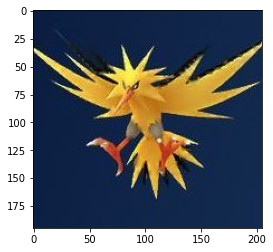

In [7]:
plt.imshow(imread(img_path))

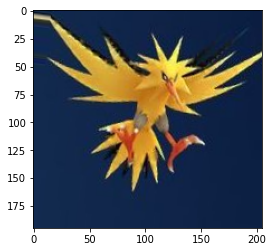

In [8]:
plt.imshow(image_gen.random_transform(imread(img_path)))

In [9]:
image_gen.flow_from_directory(train_path)

Found 5830 images belonging to 149 classes.


In [10]:
image_gen.flow_from_directory(test_path)

Found 949 images belonging to 149 classes.


<h2> Creating and training model </h2>

In [11]:
# Importing standard libraries for creating and training model

from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
# Setting the inupt image size
image_shape = (256,256,3)

In [13]:
# Creating a CNN model with 5 layers 64,128,128,128 and 256 filters each with 3x3 kernel size and pooling layers with size 2
# Adding 3 dense layers with 1024,512 neurons with final layer with 150 outputs.
# Batch Normalization and Dropout layers

model = Sequential()

model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(BatchNormalization())
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())

model.add(Dense(1024,activation='relu'))

model.add(Dropout(rate=0.25))

model.add(Dense(512,activation='relu'))

model.add(Dense(149,activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

2023-03-31 23:31:29.674801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-31 23:31:30.070189: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-31 23:31:30.070277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-31 23:31:30.074263: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-31 23:31:30.074414: I tensorflow/compile

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 64, 64, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      5

In [15]:
batch_size = 16

In [16]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 5830 images belonging to 149 classes.


In [17]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 949 images belonging to 149 classes.


In [18]:
# Defining a callback for early stopping to utilize computing resources effeciently
early_stopping = EarlyStopping(monitor='val_loss',patience=3)

In [19]:
# Training the model
results = model.fit(train_image_gen,epochs=80,validation_data=test_image_gen,callbacks=[early_stopping])

Epoch 1/80


2023-03-31 23:31:38.298202: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-31 23:31:43.578765: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-03-31 23:31:47.942749: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-31 23:31:48.436656: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f0ff332b810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-31 23:31:48.436722: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForc

103/365 [=======>......................] - ETA: 1:34 - loss: 6.2552 - accuracy: 0.0073

2023-03-31 23:32:32.035192: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


365/365 [==============================] - 164s 401ms/step - loss: 5.3934 - accuracy: 0.0062 - val_loss: 5.0220 - val_accuracy: 0.0011
Epoch 2/80
365/365 [==============================] - 141s 386ms/step - loss: 4.9170 - accuracy: 0.0125 - val_loss: 4.9390 - val_accuracy: 0.0190
Epoch 3/80
365/365 [==============================] - 144s 395ms/step - loss: 4.5532 - accuracy: 0.0247 - val_loss: 4.5292 - val_accuracy: 0.0379
Epoch 4/80
365/365 [==============================] - 142s 390ms/step - loss: 4.2947 - accuracy: 0.0482 - val_loss: 4.2609 - val_accuracy: 0.0537
Epoch 5/80
365/365 [==============================] - 144s 394ms/step - loss: 4.0578 - accuracy: 0.0633 - val_loss: 4.1872 - val_accuracy: 0.0653
Epoch 6/80
365/365 [==============================] - 146s 399ms/step - loss: 3.8311 - accuracy: 0.0907 - val_loss: 3.8873 - val_accuracy: 0.0938
Epoch 7/80
365/365 [==============================] - 161s 441ms/step - loss: 3.6686 - accuracy: 0.1230 - val_loss: 3.5427 - val_accura

In [20]:
#loss_history = pd.read_csv("loss_history.csv")

In [21]:
#model = load_model("my_cnn_model.h5")

In [22]:
#Recording the loss history
loss_history = pd.DataFrame(model.history.history)

In [23]:
loss_history.to_csv('loss_history.csv')

In [24]:
# Saving the trained model
model.save('my_cnn_model.h5')

<h2> Evaluating the model </h2>

In [25]:
model.evaluate(test_image_gen)

60/60 [==============================] - 17s 281ms/step - loss: 2.3288 - accuracy: 0.4478


[2.3288016319274902, 0.4478398263454437]

In [26]:
loss_history.head()

,loss,accuracy,val_loss,val_accuracy
0,5.393419,0.006175,5.022049,0.001054
1,4.917031,0.012521,4.939026,0.018967
2,4.553165,0.024700,4.529188,0.037935
3,4.294667,0.048199,4.260866,0.053741
4,4.057812,0.063293,4.187239,0.065332


<AxesSubplot: >

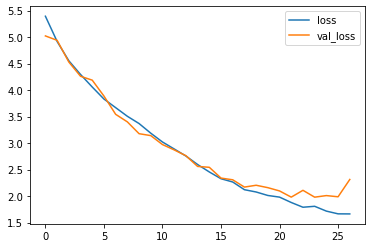

In [27]:
# plotting the loss
loss_history[['loss','val_loss']].plot()

<AxesSubplot: >

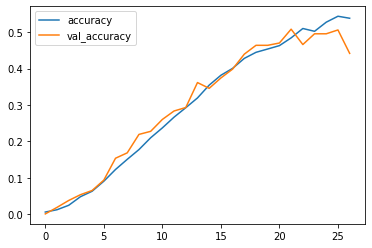

In [28]:
# plotting the accuracy
loss_history[['accuracy','val_accuracy']].plot()

<h2> Testing the model on new image </h2>

In [29]:
# Importing standard libraries for image and web url
from tensorflow.keras.preprocessing import image
from PIL import Image
import urllib.request

In [30]:
def predict_pokemon(img_url):

  # Fetching Image URL 
  url = img_url
  test_image_path = urllib.request.urlopen(url)
  
  # Using Image lib to resize image
  img = Image.open(test_image_path)
  img = img.resize((256,256))
  
  plt.imshow(img)
  plt.show()
  
  # Dropping the transperency channel if it exists
  
  img = np.array(img)
  if img.shape[2] != 3:
      img = img[:,:,:3]
  
  # Converting to array, normalizing and expanding the dims
  
  img = img/255
  my_img_array = np.expand_dims(img,axis=0)

  # Fething the prediction
  pred_class = np.argmax(model.predict(my_img_array),axis=-1)
  poke_class = {value:key for key,value in train_image_gen.class_indices.items()}
  print(poke_class[pred_class[0]])

In [31]:
img = 'http://www.pngmart.com/files/12/Pokemon-Charizard-PNG-Image.png'
img2 = 'https://www.pngkey.com/png/full/149-1492440_pokemon-jigglypuff-png-jigglypuff-pokemon.png'
img3 = 'https://smallimg.pngkey.com/png/small/62-623293_pokemon-conquest-pokemon-art.png'
img4 = 'https://smallimg.pngkey.com/png/small/1-16272_pokemon-logo-png-transparent-pokemon-vector.png'
img5 = 'https://www.pngkey.com/png/full/62-622689_fire-pokemon-png-moltres-pokemon.png'
img6 = 'https://www.pngkey.com/png/full/66-668441_jpg-library-library-redo-ultimate-mewtwo-by-pokemon.png'

In [32]:
pokemon = [img,img2,img3,img4,img5,img6]

for i in pokemon:
  predict_pokemon(i)

HTTPError: HTTP Error 403: Forbidden